['Chandigarh' 'Chennai' 'Bengaluru' 'Jaipur' 'Mumbai' 'Pune' 'Abu Dhabi'
 'Bangalore' 'Delhi' 'Hyderabad' 'Kolkata' 'Cuttack' 'Visakhapatnam'
 'Ahmedabad' 'Mohali' 'Nagpur' 'Centurion' nan 'Cape Town' 'Indore'
 'Ranchi' 'Dharamsala' 'Johannesburg' 'Durban' 'Kimberley'
 'Port Elizabeth' 'Sharjah' 'East London' 'Raipur' 'Bloemfontein']
['Royal Challengers Bangalore' 'Mumbai Indians' 'Chennai Super Kings'
 'Rajasthan Royals' 'Kings XI Punjab' 'Kolkata Knight Riders'
 'Delhi Capitals' 'Sunrisers Hyderabad']
Training Accuracy: 0.9742
Testing Accuracy: 0.9663
Model saved successfully as pipe.pkl
Target- 189
Training Accuracy: 0.9742
Testing Accuracy: 0.9663
Model saved successfully as pipe.pkl
Target- 189


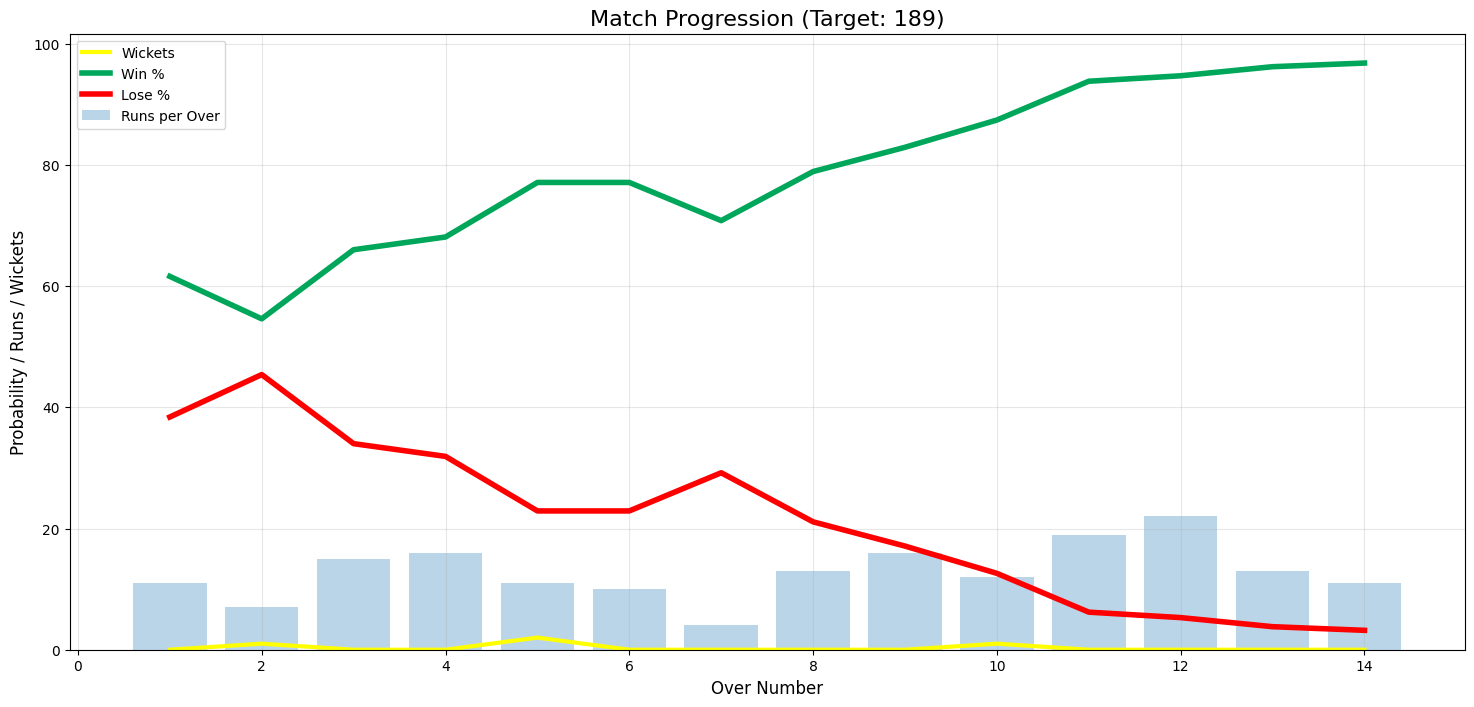


Available Cities:
['Hyderabad' 'Bangalore' 'Mumbai' 'Indore' 'Kolkata' 'Delhi' 'Chandigarh'
 'Jaipur' 'Chennai' 'Cape Town' 'Port Elizabeth' 'Durban' 'Centurion'
 'East London' 'Johannesburg' 'Kimberley' 'Bloemfontein' 'Ahmedabad'
 'Cuttack' 'Nagpur' 'Dharamsala' 'Visakhapatnam' 'Pune' 'Raipur' 'Ranchi'
 'Abu Dhabi' 'Sharjah' nan 'Mohali' 'Bengaluru']

Teams:
['Sunrisers Hyderabad', 'Mumbai Indians', 'Royal Challengers Bangalore', 'Kolkata Knight Riders', 'Kings XI Punjab', 'Chennai Super Kings', 'Rajasthan Royals', 'Delhi Capitals']

Model saved successfully as pipe.pkl


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

delivery = pd.read_csv('deliveries.csv')
match = pd.read_csv('matches.csv')

match.head()

match.shape

delivery.head()

total_score_df =delivery.groupby(['match_id','inning']).sum()['total_runs'].reset_index()

total_score_df = total_score_df[total_score_df['inning']==1]

match_df =match.merge(total_score_df[['match_id','total_runs']],left_on='id',right_on='match_id')

match_df['team1'].unique()

teams =[
    'Sunrisers Hyderabad', 'Mumbai Indians','Royal Challengers Bangalore','Kolkata Knight Riders','Kings XI Punjab',
    'Chennai Super Kings', 'Rajasthan Royals', 'Delhi Capitals'
]
match_df['team1']=match_df['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match_df['team2']=match_df['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

match_df['team1']=match_df['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
match_df['team2']=match_df['team2'].str.replace('Delhi Daredevils','Delhi Capitals')
match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]

match_df['team1'].unique()

match_df.head()

match_df = match_df[match_df['dl_applied']==0]

match_df = match_df[['match_id','city','winner','total_runs']]

delivery_df =match_df.merge(delivery,on='match_id')

delivery_df =delivery_df[delivery_df['inning']==2]

delivery_df.head()

delivery_df['current_score']=delivery_df.groupby('match_id')['total_runs_y'].cumsum()

delivery_df['runs_left'] = delivery_df['total_runs_x']-delivery_df['current_score']+1

delivery_df['balls_left']=126-(delivery_df['over']*6+delivery_df['ball'])

delivery_df.head()

delivery_df['player_dismissed']=delivery_df['player_dismissed'].fillna(0)
delivery_df['player_dismissed']=delivery_df['player_dismissed'].apply(lambda x : x if x ==0  else 1)

wickets = delivery_df.groupby('match_id')['player_dismissed'].cumsum().values

delivery_df['wickets']=10- wickets

delivery_df.head()

delivery_df['crr']=delivery_df.current_score*6/(120-delivery_df.balls_left)

delivery_df['rrr']=delivery_df.runs_left*6/delivery_df.balls_left

delivery_df = delivery_df.reset_index()


delivery_df.drop(columns='index',inplace=True)

def is_win(df):
    winner = []
    for item,row in df.iterrows():
        if row.winner == row.batting_team:
            winner.append(1)
        else:
            winner.append(0)

    return winner

delivery_df['winner']=is_win(delivery_df)

final_df =delivery_df[['match_id','batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr','winner']]

final_df =final_df.sample(final_df.shape[0])


final_df['batting_team']=final_df['batting_team'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
final_df['bowling_team']=final_df['bowling_team'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

final_df['batting_team']=final_df['batting_team'].str.replace('Delhi Daredevils','Delhi Capitals')
final_df['bowling_team']=final_df['bowling_team'].str.replace('Delhi Daredevils','Delhi Capitals')

print(final_df.city.unique())
print(final_df.batting_team.unique())


import random
cities_dict = {
    'Royal Challengers Bangalore':'Bengaluru',
    'Chennai Super Kings':'Chennai',
    'Kings XI Punjab':'Mumbai',
    'Kolkata Knight Riders':'Kolkata',
    'Delhi Capitals':'Delhi',
    'Rajasthan Royals':'Jaipur',
    'Mumbai Indians':'Mumbai',
    'Sunrisers Hyderabad':'Hyderabad',
}
final_df['city']=final_df['city'].fillna(0)
def fill_city(x):
    if x.city == 0:
        team = [x.batting_team,x.bowling_team][random.randint(0,1)]
        return cities_dict[team]
    else :
        return x.city
        

final_df['city']=final_df.apply(fill_city,axis=1)

final_df.dropna(inplace=True)
final_df =final_df[final_df.balls_left !=0]

from sklearn.model_selection import train_test_split
X = final_df.drop(columns=['winner','match_id'])
y = final_df['winner']
X_copy =final_df.drop(columns=['winner'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


ohe = OneHotEncoder()
ohe.fit_transform(X.iloc[:,:3])
category = ohe.categories_
trf = ColumnTransformer([
    ('trf',OneHotEncoder(categories=category,sparse=False,drop='first'),['batting_team','bowling_team','city'])
],remainder='passthrough')


# Create and train the pipeline with RandomForest
pipe = Pipeline([
    ('step1', trf),
    ('step2', RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=3,
        n_jobs=-1,
        random_state=42
    ))
])

# Fit the pipeline
pipe.fit(X_train, y_train)

# Calculate and print accuracy scores
train_accuracy = pipe.score(X_train, y_train)
test_accuracy = pipe.score(X_test, y_test)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Save the model
import pickle
with open('pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)

print("Model saved successfully as pipe.pkl")

y_pred = pipe.predict_proba(X_test)
# accuracy_score(y_test,y_pred)
y_pred

def match_progression(x_df,match_id,pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    
    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    
    print("Target-",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df,target

temp_df, target = match_progression(delivery_df, 513, pipe)

# Create visualization of match progression
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'], temp_df['wickets_in_over'], color='yellow', linewidth=3, label='Wickets')
plt.plot(temp_df['end_of_over'], temp_df['win'], color='#00a65a', linewidth=4, label='Win %')
plt.plot(temp_df['end_of_over'], temp_df['lose'], color='red', linewidth=4, label='Lose %')
plt.bar(temp_df['end_of_over'], temp_df['runs_after_over'], alpha=0.3, label='Runs per Over')

plt.title(f'Match Progression (Target: {target})', fontsize=16)
plt.xlabel('Over Number', fontsize=12)
plt.ylabel('Probability / Runs / Wickets', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Display unique cities and teams for verification
print("\nAvailable Cities:")
print(delivery_df['city'].unique())
print("\nTeams:")
print(teams)

# Save the model
import pickle
with open('pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)
print("\nModel saved successfully as pipe.pkl")